In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

position_mapping = {
    "TW": "Goalkeeper",
    
    "IVR": "Centre Back",
    "IVZ": "Centre Back",
    "IVL": "Centre Back",
    "RV": "Wing Back",
    "LV": "Wing Back",
    "DRM": "Wing Back",
    "DLM": "Wing Back",
    
    "DMR": "Defensive Midfielder",
    "DMZ": "Defensive Midfielder",
    "DML": "Defensive Midfielder",
    "RM": "Winger",
    "LM": "Winger",
    "HR": "Offensive Midfielder",
    "HL": "Offensive Midfielder",
    "ZO": "Offensive Midfielder",
    "ORM": "Winger",
    "OLM": "Winger",
    
    "RA": "Forward",
    "LA": "Forward",
    "STR": "Forward",
    "STZ": "Forward",
    "STL": "Forward"
}
order = ["Goalkeeper", "Centre Back", "Wing Back", "Defensive Midfielder", "Winger", "Offensive Midfielder", "Forward"]

# Kapitel 4.1

In [63]:
player_list = pd.read_csv("output/df_player_list.csv")
player_list["position_group"] = player_list["position"].map(position_mapping)
player_positions = player_list[["id", "game_id", "position_group"]].drop_duplicates()

player_level = player_list.groupby(["full_name"]).agg(
    Summe_DAS_Potential=("DAS_potential", "sum"),
    Summe_DAS_Original=("DAS", "sum"),
    Anzahl_Frames=("DAS_potential", "count")
).reset_index()

player_level["PDD"] = player_level["Summe_DAS_Potential"] / player_level["Summe_DAS_Original"]
player_level["DAS_Potential"] = player_level["Summe_DAS_Potential"] / player_level["Anzahl_Frames"]
player_level = player_level[player_level["Anzahl_Frames"] >= 10]

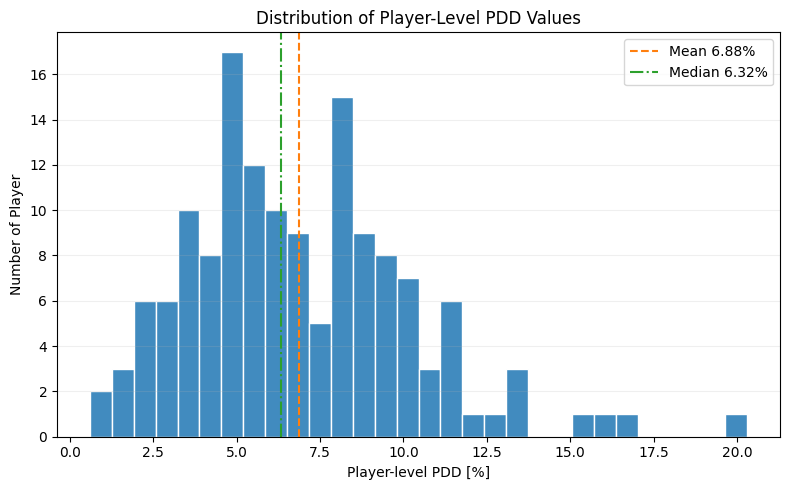

In [64]:
s = player_level["PDD"].dropna().astype(float)

if s.max() <= 1.01:
    s = s * 100
mean = s.mean()
median = s.median()

fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(s, bins=30, stat="count", edgecolor="white", alpha=0.85)
# sns.kdeplot(s, bw_method="scott", lw=2, label="KDE (Dichte)")

ax.axvline(mean, color="C1", linestyle="--", linewidth=1.5, label=f"Mean {mean:.2f}%")
ax.axvline(median, color="C2", linestyle="-.", linewidth=1.5, label=f"Median {median:.2f}%")

ax.set_xlabel("Player-level PDD [%]")
ax.set_ylabel("Number of Player")
ax.set_title("Distribution of Player-Level PDD Values")
ax.legend()
ax.grid(axis="y", alpha=0.2)

fig.tight_layout()
fig.savefig("/Users/hartmax/Desktop/Masterarbeit/Grafiken/verteilung_spieler_level.pdf", bbox_inches="tight")

plt.show()
plt.close(fig)

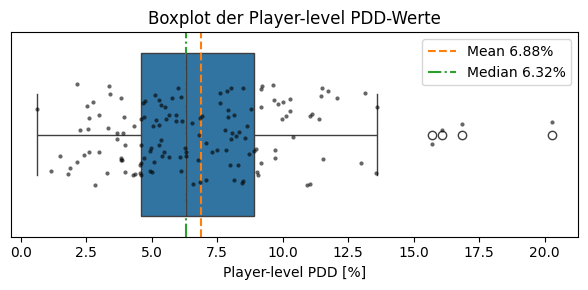

In [65]:
# Optional - > vorerst nicht in Thesis
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.boxplot(x=s, orient="h")

sns.stripplot(x=s, color="black", size=3, jitter=0.25, alpha=0.6)
ax.axvline(mean, color="C1", linestyle="--", label=f"Mean {mean:.2f}%")
ax.axvline(median, color="C2", linestyle="-.", label=f"Median {median:.2f}%")
ax.set_xlabel("Player-level PDD [%]")
ax.set_yticks([])  # single box, no y ticks needed
ax.legend(loc="upper right")
ax.set_title("Boxplot der Player-level PDD-Werte")
plt.tight_layout()
plt.show()

# Kapitel 4.2

## Kapitel 4.2.1


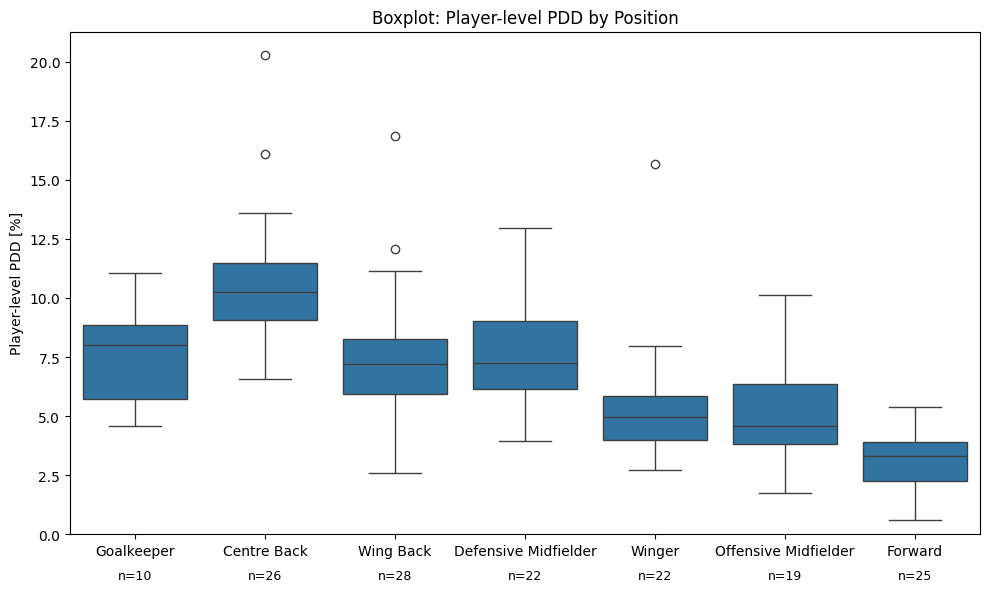

In [68]:

player_position_level = player_list.groupby(["full_name", "position_group"]).agg(
    Summe_DAS_Potential=("DAS_potential", "sum"),
    Summe_DAS_Original=("DAS", "sum"),
    Anzahl_Frames=("DAS_potential", "count")
).reset_index()
player_position_level["PDD"] = player_position_level["Summe_DAS_Potential"] / player_position_level["Summe_DAS_Original"]
player_position_level["DAS_Potential"] = player_position_level["Summe_DAS_Potential"] / player_position_level["Anzahl_Frames"]
player_position_level = player_position_level[player_position_level["Anzahl_Frames"] >= 10]

df_plot = player_position_level[["position_group", "PDD"]].copy()
df_plot["PDD"] = df_plot["PDD"].dropna().astype(float) * 100
present = [p for p in order if p in df_plot["position_group"].unique()]
df_plot["position_group"] = pd.Categorical(df_plot["position_group"], categories=present, ordered=True)

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x="position_group", y="PDD", data=df_plot, order=present, showcaps=True, boxprops={'zorder':2}, showfliers=True)
counts = df_plot.groupby("position_group", observed=True)["PDD"].count()
labels_wrapped = [p.replace(" ", "\n", 1) for p in present]

y_min, y_max = ax.get_ylim()
y_text_pos = y_min - 0.05 * (y_max - y_min)
for i, pos in enumerate(present):
        cnt = int(counts.get(pos, 0))
        ax.text(i, y_text_pos, f"n={cnt}", ha="center", va="top", fontsize=9, color="black")
# ax.set_xticks(range(len(labels_wrapped)))
# ax.set_xticklabels(labels_wrapped)
ax.set_xlabel("")
ax.set_ylabel("Player-level PDD [%]")
ax.set_title("Boxplot: Player-level PDD by Position")
ax.set_ylim(bottom=0)
fig.tight_layout()

fig.savefig("/Users/hartmax/Desktop/Masterarbeit/Grafiken/boxplot_position_pdd.pdf", bbox_inches="tight")

plt.show()
plt.close(fig)

## Kapitel 4.2.2


In [137]:
from streamlit import latex


player_ranking = player_position_level[["full_name", "PDD", "Anzahl_Frames", "position_group"]].copy()
player_ranking["rank_overall"] = player_ranking["PDD"].rank(method="min", ascending=True).astype(int)
player_ranking = player_ranking.sort_values(["position_group", "PDD"], ascending=[True, True])
player_ranking["rank_position"] = player_ranking.groupby("position_group")["PDD"].rank(method="min", ascending=True).astype(int)
player_ranking["PDD(%)"] = (player_ranking["PDD"] * 100).round(2)
player_ranking.rename(columns={"full_name": "Player", "Anzahl_Frames": "Number of Frames", "rank_position": "Rank"}, inplace=True)

# Centre Backs
ranking_cb = pd.concat([
    player_ranking[player_ranking["position_group"] == "Centre Back"].head(5),
    player_ranking[player_ranking["position_group"] == "Centre Back"].tail(5)
]).drop_duplicates().reset_index(drop=True)[["Rank", "Player", "PDD(%)", "Number of Frames"]]

latex_cb = ranking_cb.to_latex(
    index=False,
    escape=True,
    float_format="%.2f\\%%"
)
with open("/Users/hartmax/Desktop/Masterarbeit/Tabellen/ranking_cb.tex", "w", encoding="utf-8") as f:
    f.write(latex_cb)
    
# Wing Backs
ranking_wb = pd.concat([
    player_ranking[player_ranking["position_group"] == "Wing Back"].head(5),
    player_ranking[player_ranking["position_group"] == "Wing Back"].tail(5)
]).drop_duplicates().reset_index(drop=True)[["Rank", "Player", "PDD(%)", "Number of Frames"]]

latex_wb = ranking_wb.to_latex(
    index=False,
    escape=True,
    float_format="%.2f\\%%"
)
with open("/Users/hartmax/Desktop/Masterarbeit/Tabellen/ranking_wb.tex", "w", encoding="utf-8") as f:
    f.write(latex_wb)
    
# Defensive Midfielder
ranking_dm = pd.concat([
    player_ranking[player_ranking["position_group"] == "Defensive Midfielder"].head(5),
    player_ranking[player_ranking["position_group"] == "Defensive Midfielder"].tail(5)
]).drop_duplicates().reset_index(drop=True)[["Rank", "Player", "PDD(%)", "Number of Frames"]]

latex_dm = ranking_dm.to_latex(
    index=False,
    escape=True,
    float_format="%.2f\\%%"
)
with open("/Users/hartmax/Desktop/Masterarbeit/Tabellen/ranking_dm.tex", "w", encoding="utf-8") as f:
    f.write(latex_dm)
    
    
# Alle Spieler
player_ranking = player_ranking.sort_values(["PDD"], ascending=[True])
ranking_all = pd.concat([
    player_ranking.head(5),
    player_ranking.tail(5)
]).drop_duplicates().reset_index(drop=True)[["Rank", "Player", "PDD(%)", "Number of Frames", "position_group"]]

# latex_dm = ranking_dm.to_latex(
#     index=False,
#     escape=True,
#     float_format="%.2f\\%%"
# )
ranking_all

,Rank,Player,PDD(%),Number of Frames,position_group
0,1,Eric Maxim Choupo-Moting,0.61,15,Forward
1,2,Tim Lemperle,1.16,19,Forward
2,3,Jan Uwe Thielmann,1.49,32,Forward
3,1,Elione Fernandes Neto,1.76,12,Offensive Midfielder
4,4,Daniel Ginczek,1.81,75,Forward
5,24,Rick van Drongelen,13.61,90,Centre Back
6,22,Daniel Patrick Hanslik,15.69,10,Winger
7,25,Kevin Kraus,16.09,78,Centre Back
8,28,Saidy Janko,16.85,82,Wing Back
9,26,Edmond Fayçal Tapsoba,20.30,97,Centre Back


## Kapitel 4.2.3

In [132]:
player_position_count = player_position_level.groupby("full_name")["position_group"].nunique().reset_index()
player_position_count = player_position_count[player_position_count["position_group"] > 1]
player_position_count = player_position_count[["full_name"]].merge(player_position_level, on="full_name")
player_position_count["pos_count"] = player_position_count.groupby("full_name").cumcount()+1
player_position_count["pos_count"] = player_position_count["pos_count"].astype(str)

player_double_positions = pd.pivot_table(player_position_count, values=["PDD", "position_group"], index="full_name", columns="pos_count", aggfunc="first").reset_index()
player_double_positions.columns = player_double_positions.columns.map('_'.join)

player_double_positions.rename(columns={"full_name_": "Player", "position_group_1": "Position 1", "position_group_2": "Position 2"}, inplace=True)
player_double_positions["PDD(%) 1"] = (player_double_positions["PDD_1"] * 100).round(2)
player_double_positions["PDD(%) 2"] = (player_double_positions["PDD_2"] * 100).round(2)
player_double_positions = player_double_positions[["Player", "Position 1", "PDD(%) 1", "Position 2", "PDD(%) 2"]]

latex_double_position = player_double_positions.to_latex(
    index=False,
    escape=True,
    float_format="%.2f\\%%"
)
with open("/Users/hartmax/Desktop/Masterarbeit/Tabellen/double_position.tex", "w", encoding="utf-8") as f:
    f.write(latex_double_position)